# QKeras dense layer comparison


## Imports

In [1]:
import tensorflow as tf
import keras
import numpy as np
import time
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import plotting


2022-04-26 10:45:22.401475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
2022-04-26 10:45:22.401494: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/atlas/bonnet/hls4ml/hls4ml/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


## Data creation 

In [2]:
#Creating a simple dataset using numpy

x = np.linspace(-1, 1, 1000)
y = np.sin(5*x)

x_val = np.linspace(-1, 1, 100)
y_val = np.sin(5*x_val)

x_test = np.linspace(-1, 1, 1000)
y_test = np.sin(5*x_test)



In [3]:
import os
print(os.environ['LD_LIBRARY_PATH'])
print('and\n', os.environ['PATH'])

/cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
and
 /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/altera/21.1.0.169.pro/gcc/bin:/inteltools/altera/21.1.0.169.pro/hls/bin:/inteltools/altera/21.1.0.169.pro/qsys/bin:/inteltools/altera/21.1.0.169.pro/quartus/bin:/inteltools/mentor/2018-19/RHELx86/QUESTA-CORE-PRIME_10.7c/questasim/linux_x86_64:/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/bin:/atlas/bonnet/miniconda3/condabin:/usr/lib64/qt-3.3/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/openssh/bin:/usr/local/sbin:/usr/local/texlive/2019/bin/x86_64-linux


## Settings

In [13]:
output = 1
integer = (3)

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+2)*3

def bit_width(i): return {'bits': (i+2)*3, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 5

nbr_epoch = 15

def units(j): return (j+3)*2
units_range = 5

## Classic network

In [5]:
def normal_model (units_parameter):
    checkpoint_filepath = '/atlas/bonnet/tmp/model_checkpoint'

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.00001, verbose=1)

    d_model = Sequential()

    d_model.add(Dense(units_parameter,input_dim= 1,activation='relu', name='dense'))
    d_model.add(Dense(units_parameter,activation='relu', name='dense_1'))
    d_model.add(Dense(output, activation='linear', name='dense_2'))
    d_model.compile(loss="mse", optimizer=Adam(lr=0.001))

    d_model.summary()

    d_model.fit(x, y, validation_data= (x_val,y_val), epochs=80, batch_size=10, callbacks=[reduce_lr,model_checkpoint_callback])

    d_model.load_weights(checkpoint_filepath)

    return d_model

def model_saving (): 
    models =[]
    for i in range(units_range):
        units_parameter = units (i)
        models.append( normal_model (units_parameter))
        print('number of units ', units_parameter)        
    return models

models = model_saving()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 12        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80


2022-04-26 10:46:36.841196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 10:46:36.841515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21.1.0.169.pro/hls/host/linux64/lib
2022-04-26 10:46:36.841573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/gcc/9.2.0/x86_64-centos7/bin/:/inteltools/altera/21.1.0.169.pro/gcc/lib64:/inteltools/altera/21

100/100 [==============================] - 0s 2ms/step - loss: 0.5043 - val_loss: 0.4925 - lr: 0.0010
Epoch 2/80
100/100 [==============================] - 0s 2ms/step - loss: 0.4769 - val_loss: 0.4615 - lr: 0.0010
Epoch 3/80
100/100 [==============================] - 0s 1ms/step - loss: 0.4438 - val_loss: 0.4232 - lr: 0.0010
Epoch 4/80
100/100 [==============================] - 0s 895us/step - loss: 0.4045 - val_loss: 0.3818 - lr: 0.0010
Epoch 5/80
100/100 [==============================] - 0s 895us/step - loss: 0.3612 - val_loss: 0.3365 - lr: 0.0010
Epoch 6/80
100/100 [==============================] - 0s 932us/step - loss: 0.3147 - val_loss: 0.2895 - lr: 0.0010
Epoch 7/80
100/100 [==============================] - 0s 886us/step - loss: 0.2681 - val_loss: 0.2425 - lr: 0.0010
Epoch 8/80
100/100 [==============================] - 0s 923us/step - loss: 0.2233 - val_loss: 0.1997 - lr: 0.0010
Epoch 9/80
100/100 [==============================] - 0s 2ms/step - loss: 0.1831 - val_loss: 0.16

## Quantized network : 

In [14]:
def quantized_model (bits, units, original_weights):
    qcheckpoint_filepath = '/atlas/bonnet/tmp/qmodel_checkpoint'
    qmodel_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=qcheckpoint_filepath,
                                                                    save_weights_only=True,
                                                                    monitor='val_loss',
                                                                    mode='min',
                                                                    save_best_only=True)


    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

    qd_model = Sequential()
    
    qd_model.add(QDense(units,
                        input_dim= 1,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    
    qd_model.add(QDense(units,
                        activation='relu',   
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))    
    #qd_model.add(QActivation(activation=quantized_relu(bits=bits['bits'], integer = bits['integer']), name='relu1'))                   
    qd_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)))
    #qd_model.add(QActivation(activation=quantized_bits(**bits), name='linear1'))
    qd_model.compile(loss="mse", optimizer=Adam(lr=0.0001))
    
    qd_model.summary()
    
    #using the weight from the classic network as a base
    qd_model.set_weights(original_weights.get_weights())
    qd_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_epoch, callbacks=[qmodel_checkpoint_callback,reduce_lr])
    qd_model.load_weights(qcheckpoint_filepath)

    return qd_model

def qmodel_saving (): 
    qmodels =[]
    for i in range(bits_range):
        var_units= []
        for j in range(units_range):
            bits_parameter = bit_width(i)
            units_parameter = units(j)
            var_units.append( quantized_model(bits_parameter,units_parameter, models[j]))
        qmodels.append(var_units)
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_saving()
        


Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_dense_150 (QDense)        (None, 6)                 12        
                                                                 
 q_dense_151 (QDense)        (None, 6)                 42        
                                                                 
 q_dense_152 (QDense)        (None, 1)                 7         
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15


/atlas/bonnet/miniconda3/envs/hls4ml-tutorial/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


32/32 [==============================] - 1s 7ms/step - loss: 0.0387 - val_loss: 0.0397 - lr: 1.0000e-04
Epoch 2/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0387 - val_loss: 0.0397 - lr: 1.0000e-04
Epoch 3/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0387 - val_loss: 0.0397 - lr: 1.0000e-04
Epoch 4/15
32/32 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0304 - lr: 1.0000e-04
Epoch 5/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0295 - val_loss: 0.0304 - lr: 1.0000e-04
Epoch 6/15
32/32 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0291 - lr: 1.0000e-04
Epoch 7/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0291 - lr: 1.0000e-04
Epoch 8/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0291 - lr: 1.0000e-04
Epoch 9/15
32/32 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 

In [15]:
print((qmodels)) 

for i  in range (bits_range):   
    print(quantized_bits(**bit_width(i)))

[[<keras.engine.sequential.Sequential object at 0x7f1d00a4b650>, <keras.engine.sequential.Sequential object at 0x7f1d02b50950>, <keras.engine.sequential.Sequential object at 0x7f1d40195b90>, <keras.engine.sequential.Sequential object at 0x7f1d03d86f50>, <keras.engine.sequential.Sequential object at 0x7f1d00e59890>], [<keras.engine.sequential.Sequential object at 0x7f1d02a10150>, <keras.engine.sequential.Sequential object at 0x7f1d02da0c90>, <keras.engine.sequential.Sequential object at 0x7f1cdff34990>, <keras.engine.sequential.Sequential object at 0x7f1d02b21b10>, <keras.engine.sequential.Sequential object at 0x7f1d00d8e110>], [<keras.engine.sequential.Sequential object at 0x7f1d00992fd0>, <keras.engine.sequential.Sequential object at 0x7f1d025618d0>, <keras.engine.sequential.Sequential object at 0x7f1d032ab0d0>, <keras.engine.sequential.Sequential object at 0x7f1d026705d0>, <keras.engine.sequential.Sequential object at 0x7f1d03539d90>], [<keras.engine.sequential.Sequential object at 0

## Normal network, Quantized weights

In [65]:
configu = d_model.get_config()
tmp_model = Sequential().from_config(configu)
tmp_models = []

print(configu)   

for i in range (bits_range) :   
    tmp_model.set_weights([quantized_bits(**bit_width(i))(n) for n in qmodels[i].get_weights()])
    tmp_models.append(tmp_model)


NameError: name 'd_model' is not defined

## HLS CONVERSION of the Keras model, every layer

In [66]:
#HLS CONVERSION of the Keras model, every layer

closs = []
qcloss = []
qchloss = []
ptq_results = []
breaking_points = [] 
bits_nbr = []

for i in range (bits_range):
    breaking_point = units(0)
    units_nbr = []
    mse_ratio = []

    for j in range (units_range):
        print(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        conf = hls4ml.utils.config_from_keras_model( models[j], granularity='name')
        conf['LayerName']['dense']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        conf['LayerName']['dense_relu']['Precision'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_relu']['table_t'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        conf['LayerName']['dense_1']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_1']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_1']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        conf['LayerName']['dense_1_relu']['Precision'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_1_relu']['table_t'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        conf['LayerName']['dense_2']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_2']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_2']['Precision']['result'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        
        conf['LayerName']['dense_2_linear']['Precision'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_2_linear']['table_t'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        print(conf)
            
        hls_model = hls4ml.converters.convert_from_keras_model(models[j],
                                                                hls_config=conf,
                                                                output_dir='models/hls_models',
                                                                part='1SG280HU2F50E2VG',
                                                                backend='Quartus')
        hls_model.compile()
        
        y_qchls = hls_model.predict(x_test.reshape(x_test.shape[0],1))
        ptq_results.append(y_qchls)
        y_keras = models[j].predict(x_test)
        
        units_nbr.append(units(j))
        
        closs.append(mse(y_test, y_keras))
        qchloss.append(mse(y_test, y_qchls))
        
        #Implementation of the breaking point

        ratio =(abs(mse(y_test, y_keras) - mse(y_test, y_qchls))/mse(y_test, y_keras))
        print(f'ratio of bits = {bit_lenghts(i)} and units =  {units(j)}',ratio)
        mse_ratio.append(ratio)
        if  (ratio>0.02):
            print('new bp detected')
            breaking_point = units(j)

        #Plotting of the predictions
        plt.figure()
        plt.plot(y_qchls)
        plt.plot(y_keras)    
        plt.legend(['keras+hls', 'keras'])
        plt.title(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        plt.show()


    #plotting of the evolution of the breaking points through the number of units with a given a bit lenghts
    breaking_points.append(breaking_point)
    bits_nbr.append(bit_lenghts(i))
    plt.figure()
    plt.plot(mse_ratio)
    plt.xticks(np.arange(len(units_nbr)), [f"{units}" for units in units_nbr])
    plt.xlabel('units per layer')
    plt.ylabel('ratio')

    plt.title(f'MSE ratio for bits = {bit_lenghts(i)}')

    plt.show()

#plotting the breaking points regarding the nbr of bits and the nbr of units 
plt.figure()
plt.plot(breaking_points)
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])
plt.title('Breaking points evolution regarding the number of units and the bitwidth')

plt.show()

PTQ : bitwidths of (12,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<12,4>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<12,4>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>', 'result': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<12,4>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<12

KeyboardInterrupt: 

([<matplotlib.axis.XTick at 0x7febf57c8110>,
 [Text(0, 0, '<12, 3>'),
  Text(1, 0, '<15, 3>'),
  Text(2, 0, '<18, 3>'),
  Text(3, 0, '<21, 3>'),
  Text(4, 0, '<24, 3>')])

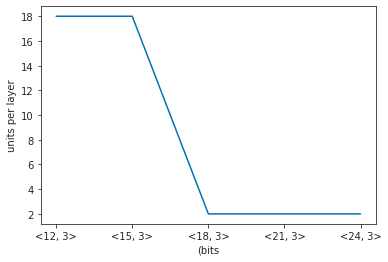

In [ ]:

plt.plot(breaking_points)

plt.xlabel('(bits')
plt.ylabel('units per layer')


plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])



## HLS CONVERSION of the Keras model, only dense layer

PTQ : bitwidths of (6,2,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,3>', 'bias': 'ap_fixed<6,3>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,3>', 'bias': 'ap_fixed<6,3>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}

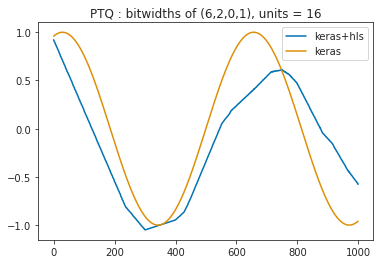

PTQ : bitwidths of (6,2,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,3>', 'bias': 'ap_fixed<6,3>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,3>', 'bias': 'ap_fixed<6,3>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

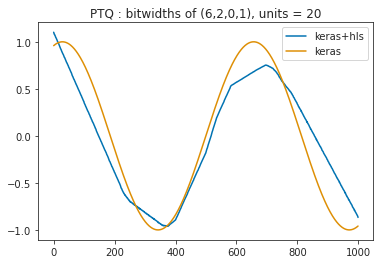

PTQ : bitwidths of (6,2,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: dense_input, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (relu), layer name: dense
Layer name: dense_1, layer type: Dense
  -> Activation (relu), layer name: dense_1
Layer name: dense_2, layer type: Dense
  -> Activation (linear), layer name: dense_2
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'dense_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'dense': {'Precision': {'weight': 'ap_fixed<6,3>', 'bias': 'ap_fixed<6,3>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'}, 'dense_1': {'Precision': {'weight': 'ap_fixed<6,3>', 'bias': 'ap_fixed<6,3>', 'result': 'ap_fixed<16,6>'}, 'ReuseFactor': 1}, 'dense_1_relu': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'table_t': 'ap_fixed<18,8>'

KeyboardInterrupt: 

In [ ]:
#HLS CONVERSION of the Keras model, only dense layer

closs = []
qcloss = []
qchloss = []
ptq_results = []
breaking_points = [] 

bit_scale = []
for i in range (5):
    breaking_point = units(0)
    mse_ratio = []
    for j in range (9):
        print(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        conf = hls4ml.utils.config_from_keras_model( models[j], granularity='name')
        conf['LayerName']['dense']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        conf['LayerName']['dense_1']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_1']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'


        conf['LayerName']['dense_2']['Precision']['weight'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'
        conf['LayerName']['dense_2']['Precision']['bias'] = f'ap_fixed<{bit_lenghts(i)},{integer+1}>'

        print(conf)
            
        hls_model = hls4ml.converters.convert_from_keras_model(models[j],
                                                                hls_config=conf,
                                                                output_dir='models/hls_models',
                                                                part='1SG280HU2F50E2VG',
                                                                backend='Quartus')
        hls_model.compile()
        y_qchls = hls_model.predict(x_test.reshape(x_test.shape[0],1))
        ptq_results.append(y_qchls)
        y_keras = models[j].predict(x_test)
        closs.append(mse(y_test, y_keras))
        qchloss.append(mse(y_test, y_qchls))
        mse_ratio.append((abs(mse(y_test, y_keras) - mse(y_test, y_qchls))/mse(y_test, y_keras)))
        if  ((abs(mse(y_test, y_keras) - mse(y_test, y_qchls))/mse(y_test, y_keras))>0.02):
            print('new bp detected')
            breaking_point = units(j)

        bit_scale.append(bit_lenghts(i))
        plt.figure()
        plt.plot(y_qchls)
        plt.plot(y_test)    
        plt.legend(['keras+hls', 'keras'])
        plt.title(f'PTQ : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)*2}')
        plt.show()
    breaking_points.append(breaking_point)
    plt.figure()
    plt.plot(bit_scale,mse_ratio)


plt.figure()
plt.plot(breaking_points)
plt.xlabel('bits')
plt.ylabel('Units per layer')

plt.show()



Text(0, 0.5, 'units')

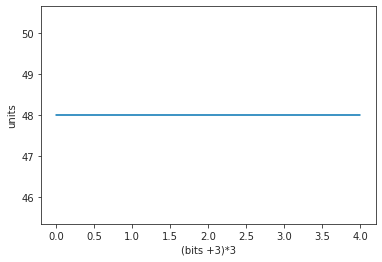

In [ ]:
plt.plot(breaking_points)
plt.xlabel('(bits +3)*3')
plt.ylabel('units')

## HLS CONVERSION of the QKeras model

QAT : bitwidths of (6,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_150_input, layer type: Input
Layer name: q_dense_150, layer type: QDense
Layer name: q_dense_151, layer type: QDense
Layer name: q_dense_152, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_150_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_150': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_151': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_152': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_150_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_150, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_151, layer type: Q

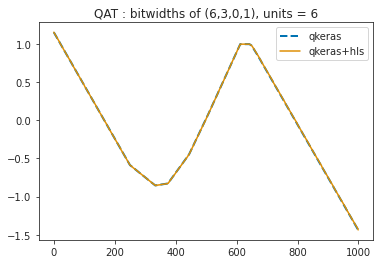

QAT : bitwidths of (6,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_153_input, layer type: Input
Layer name: q_dense_153, layer type: QDense
Layer name: q_dense_154, layer type: QDense
Layer name: q_dense_155, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_153_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_153': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_154': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_155': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_153_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_153, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_154, layer type: Q

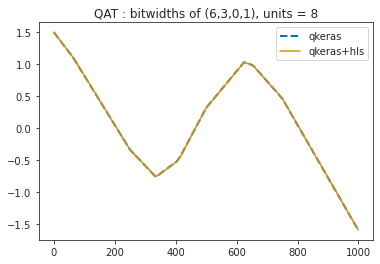

QAT : bitwidths of (6,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_156_input, layer type: Input
Layer name: q_dense_156, layer type: QDense
Layer name: q_dense_157, layer type: QDense
Layer name: q_dense_158, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_156_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_156': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_157': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_158': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_156_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_156, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_157, layer type:

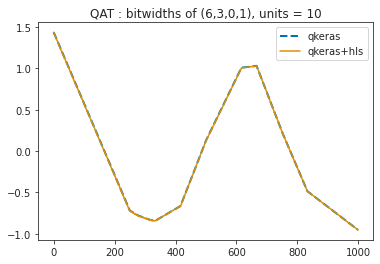

QAT : bitwidths of (6,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_159_input, layer type: Input
Layer name: q_dense_159, layer type: QDense
Layer name: q_dense_160, layer type: QDense
Layer name: q_dense_161, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_159_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_159': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_160': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_161': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_159_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_159, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_160, layer type:

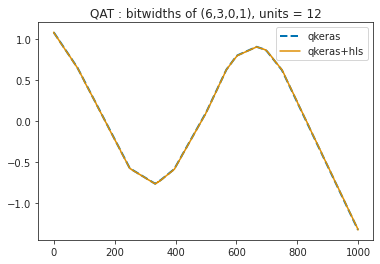

QAT : bitwidths of (6,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_162_input, layer type: Input
Layer name: q_dense_162, layer type: QDense
Layer name: q_dense_163, layer type: QDense
Layer name: q_dense_164, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_162_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_162': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_163': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}, 'q_dense_164': {'Precision': {'weight': 'ap_fixed<6,4>', 'bias': 'ap_fixed<6,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_162_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_162, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_163, layer type:

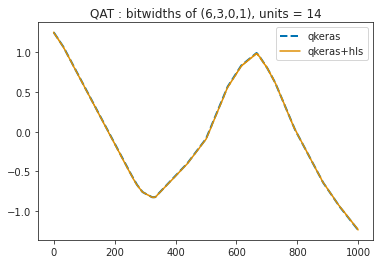

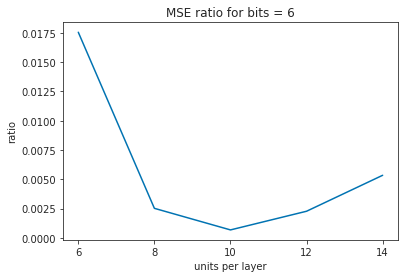

QAT : bitwidths of (9,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_165_input, layer type: Input
Layer name: q_dense_165, layer type: QDense
Layer name: q_dense_166, layer type: QDense
Layer name: q_dense_167, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_165_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_165': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_166': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_167': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_165_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_165, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_166, layer type: Q

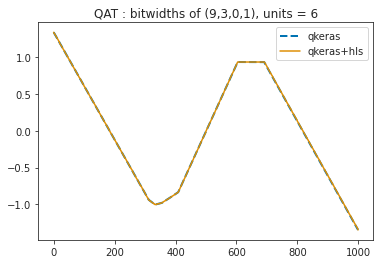

QAT : bitwidths of (9,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_168_input, layer type: Input
Layer name: q_dense_168, layer type: QDense
Layer name: q_dense_169, layer type: QDense
Layer name: q_dense_170, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_168_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_168': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_169': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_170': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_168_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_168, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_169, layer type: Q

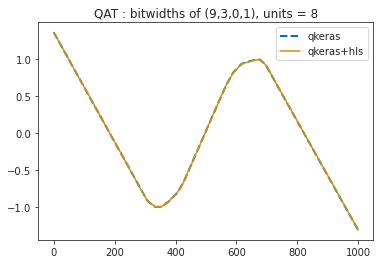

QAT : bitwidths of (9,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_171_input, layer type: Input
Layer name: q_dense_171, layer type: QDense
Layer name: q_dense_172, layer type: QDense
Layer name: q_dense_173, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_171_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_171': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_172': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_173': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_171_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_171, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_172, layer type:

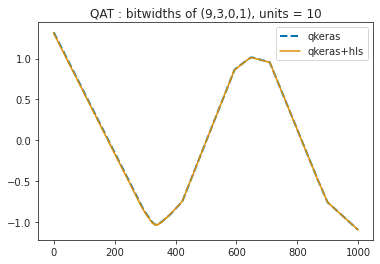

QAT : bitwidths of (9,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_174_input, layer type: Input
Layer name: q_dense_174, layer type: QDense
Layer name: q_dense_175, layer type: QDense
Layer name: q_dense_176, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_174_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_174': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_175': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_176': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_174_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_174, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_175, layer type:

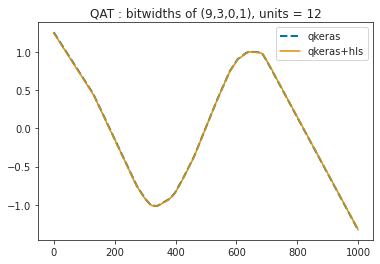

QAT : bitwidths of (9,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_177_input, layer type: Input
Layer name: q_dense_177, layer type: QDense
Layer name: q_dense_178, layer type: QDense
Layer name: q_dense_179, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_177_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_177': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_178': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}, 'q_dense_179': {'Precision': {'weight': 'ap_fixed<9,4>', 'bias': 'ap_fixed<9,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_177_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_177, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_178, layer type:

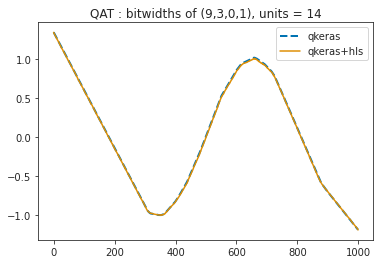

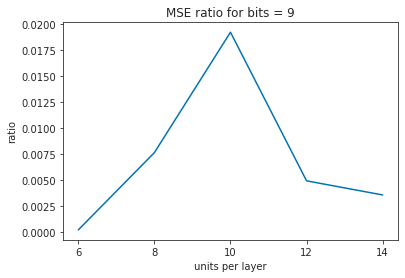

QAT : bitwidths of (12,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_180_input, layer type: Input
Layer name: q_dense_180, layer type: QDense
Layer name: q_dense_181, layer type: QDense
Layer name: q_dense_182, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_180_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_180': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_181': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_182': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_180_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_180, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_181, layer 

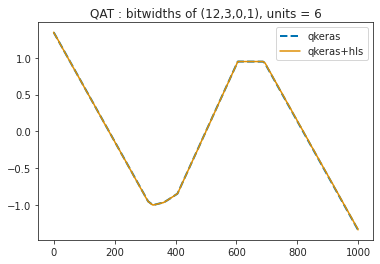

QAT : bitwidths of (12,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_183_input, layer type: Input
Layer name: q_dense_183, layer type: QDense
Layer name: q_dense_184, layer type: QDense
Layer name: q_dense_185, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_183_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_183': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_184': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_185': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_183_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_183, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_184, layer 

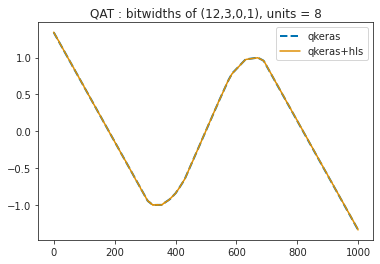

QAT : bitwidths of (12,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_186_input, layer type: Input
Layer name: q_dense_186, layer type: QDense
Layer name: q_dense_187, layer type: QDense
Layer name: q_dense_188, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_186_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_186': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_187': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_188': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_186_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_186, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_187, laye

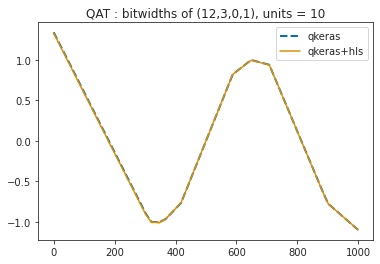

QAT : bitwidths of (12,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_189_input, layer type: Input
Layer name: q_dense_189, layer type: QDense
Layer name: q_dense_190, layer type: QDense
Layer name: q_dense_191, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_189_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_189': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_190': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_191': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_189_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_189, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_190, laye

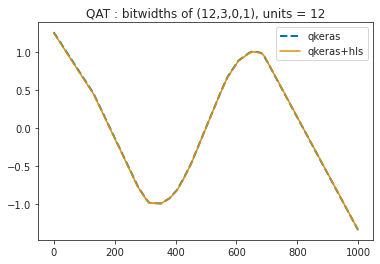

QAT : bitwidths of (12,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_192_input, layer type: Input
Layer name: q_dense_192, layer type: QDense
Layer name: q_dense_193, layer type: QDense
Layer name: q_dense_194, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_192_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_192': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_193': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}, 'q_dense_194': {'Precision': {'weight': 'ap_fixed<12,4>', 'bias': 'ap_fixed<12,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_192_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_192, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_193, laye

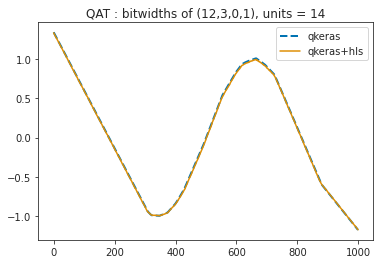

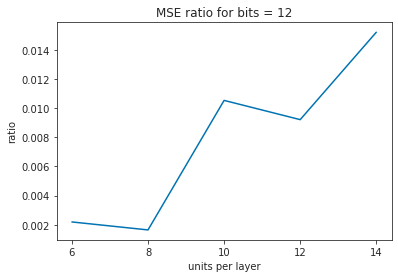

QAT : bitwidths of (15,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_195_input, layer type: Input
Layer name: q_dense_195, layer type: QDense
Layer name: q_dense_196, layer type: QDense
Layer name: q_dense_197, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_195_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_195': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_196': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_197': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_195_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_195, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_196, layer 

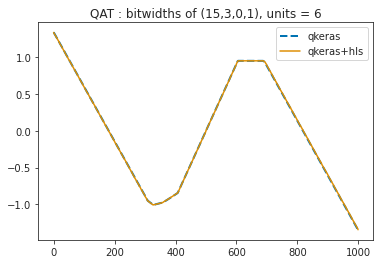

QAT : bitwidths of (15,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_198_input, layer type: Input
Layer name: q_dense_198, layer type: QDense
Layer name: q_dense_199, layer type: QDense
Layer name: q_dense_200, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_198_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_198': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_199': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_200': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_198_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_198, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_199, layer 

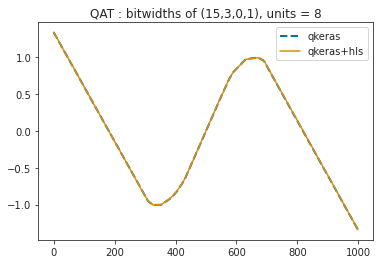

QAT : bitwidths of (15,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_201_input, layer type: Input
Layer name: q_dense_201, layer type: QDense
Layer name: q_dense_202, layer type: QDense
Layer name: q_dense_203, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_201_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_201': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_202': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_203': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_201_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_201, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_202, laye

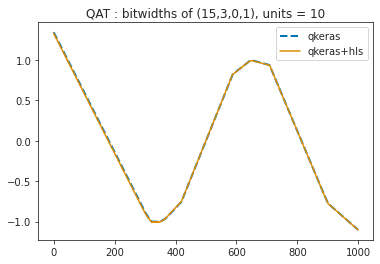

QAT : bitwidths of (15,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_204_input, layer type: Input
Layer name: q_dense_204, layer type: QDense
Layer name: q_dense_205, layer type: QDense
Layer name: q_dense_206, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_204_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_204': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_205': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_206': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_204_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_204, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_205, laye

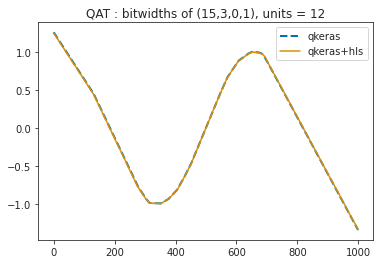

QAT : bitwidths of (15,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_207_input, layer type: Input
Layer name: q_dense_207, layer type: QDense
Layer name: q_dense_208, layer type: QDense
Layer name: q_dense_209, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_207_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_207': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_208': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}, 'q_dense_209': {'Precision': {'weight': 'ap_fixed<15,4>', 'bias': 'ap_fixed<15,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_207_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_207, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_208, laye

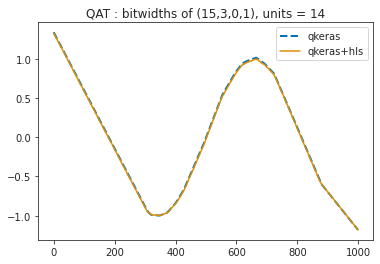

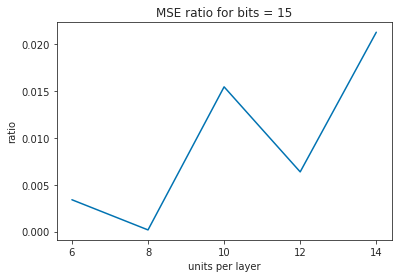

QAT : bitwidths of (18,3,0,1), units = 6
Interpreting Sequential
Topology:
Layer name: q_dense_210_input, layer type: Input
Layer name: q_dense_210, layer type: QDense
Layer name: q_dense_211, layer type: QDense
Layer name: q_dense_212, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_210_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_210': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_211': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_212': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_210_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_210, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 6]
Layer name: q_dense_211, layer 

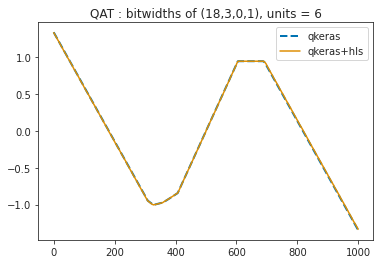

QAT : bitwidths of (18,3,0,1), units = 8
Interpreting Sequential
Topology:
Layer name: q_dense_213_input, layer type: Input
Layer name: q_dense_213, layer type: QDense
Layer name: q_dense_214, layer type: QDense
Layer name: q_dense_215, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_213_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_213': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_214': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_215': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_213_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_213, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 8]
Layer name: q_dense_214, layer 

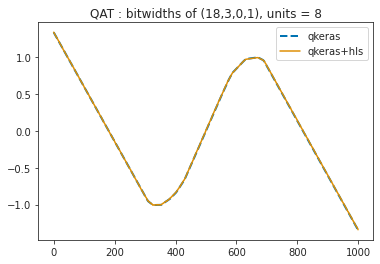

QAT : bitwidths of (18,3,0,1), units = 10
Interpreting Sequential
Topology:
Layer name: q_dense_216_input, layer type: Input
Layer name: q_dense_216, layer type: QDense
Layer name: q_dense_217, layer type: QDense
Layer name: q_dense_218, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_216_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_216': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_217': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_218': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_216_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_216, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 10]
Layer name: q_dense_217, laye

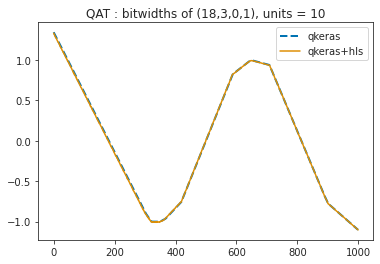

QAT : bitwidths of (18,3,0,1), units = 12
Interpreting Sequential
Topology:
Layer name: q_dense_219_input, layer type: Input
Layer name: q_dense_219, layer type: QDense
Layer name: q_dense_220, layer type: QDense
Layer name: q_dense_221, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_219_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_219': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_220': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_221': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_219_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_219, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 12]
Layer name: q_dense_220, laye

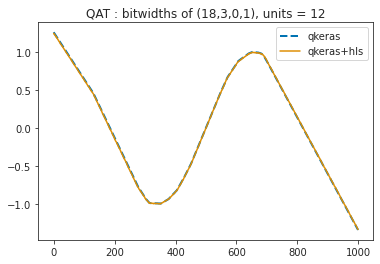

QAT : bitwidths of (18,3,0,1), units = 14
Interpreting Sequential
Topology:
Layer name: q_dense_222_input, layer type: Input
Layer name: q_dense_222, layer type: QDense
Layer name: q_dense_223, layer type: QDense
Layer name: q_dense_224, layer type: QDense
{'Model': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'Strategy': 'Latency'}, 'LayerName': {'q_dense_222_input': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_dense_222': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_223': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}, 'q_dense_224': {'Precision': {'weight': 'ap_fixed<18,4>', 'bias': 'ap_fixed<18,4>'}, 'ReuseFactor': 1}}}
Interpreting Sequential
Topology:
Layer name: q_dense_222_input, layer type: InputLayer, input shapes: [[None, 1]], output shape: [None, 1]
Layer name: q_dense_222, layer type: QDense, input shapes: [[None, 1]], output shape: [None, 14]
Layer name: q_dense_223, laye

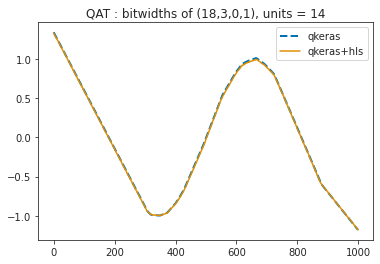

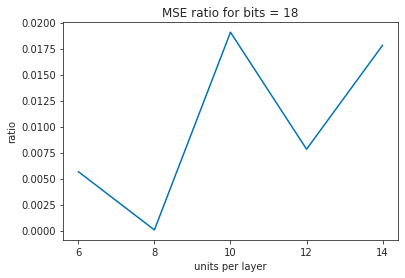

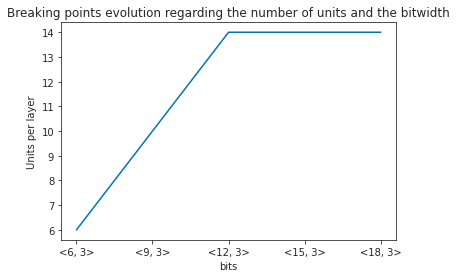

In [16]:
####### quantized model 

breaking_points = [] 
bits_nbr = []
qat_results = []
qloss = []
qhloss = []

for i in range (bits_range):
    breaking_point = units(0)
    units_nbr = []
    mse_ratio = []

    for j in range (units_range):
        print(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        conf = hls4ml.utils.config_from_keras_model(qmodels[i][j], granularity='name')
        print(conf)

        hls_qmodel = hls4ml.converters.convert_from_keras_model(qmodels[i][j],
                                                            hls_config=conf,
                                                            output_dir='models/hls_models',
                                                            part='1SG280HU2F50E2VG',
                                                            backend='Quartus')
                                    
        hls_qmodel.compile()

        y_qkeras = qmodels[i][j].predict(x_test)
        y_qhls = hls_qmodel.predict(x_test.reshape(x_test.shape[0],1))
        
        qat_results.append(y_qhls)
        
        
        qhloss.append(mse(y_test, y_qhls))
        qloss.append(mse(y_test, y_qkeras))
        
        units_nbr.append(units(j))
        
        #Implementation of the breaking point
        ratio =(abs(mse(y_test, y_qkeras) - mse(y_test, y_qhls))/mse(y_test, y_qkeras))
        print(f'ratio of bits = {bit_lenghts(i)} and units =  {units(j)}',ratio)
        mse_ratio.append(ratio)
        if  (ratio>0.01):
            print('new bp detected')
            breaking_point = units(j)

        #Plotting of the predictions
        plt.figure()
        plt.plot(y_qkeras, '--', linewidth=2)
        plt.plot(y_qhls)    
        plt.legend(['qkeras', 'qkeras+hls'])
        plt.title(f'QAT : bitwidths of ({bit_lenghts(i)},{integer},0,1), units = {units(j)}')
        plt.show()
       
    


    #plotting of the evolution of the breaking points through the number of units with a given a bit lenghts
    breaking_points.append(breaking_point)
    bits_nbr.append(bit_lenghts(i))
    plt.figure()
    plt.plot(mse_ratio)
    plt.xticks(np.arange(len(units_nbr)), [f"{units}" for units in units_nbr])
    plt.xlabel('units per layer')
    plt.ylabel('ratio')

    plt.title(f'MSE ratio for bits = {bit_lenghts(i)}')

    plt.show()

plt.figure()
plt.plot(breaking_points)
plt.xlabel('bits')
plt.ylabel('Units per layer')
plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])
plt.title('Breaking points evolution regarding the number of units and the bitwidth')

plt.show()


([<matplotlib.axis.XTick at 0x7feb0451df90>,
 [Text(0, 0, '<12, 3>'),
  Text(1, 0, '<15, 3>'),
  Text(2, 0, '<18, 3>'),
  Text(3, 0, '<21, 3>'),
  Text(4, 0, '<24, 3>')])

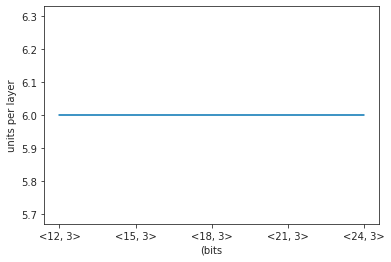

In [69]:
plt.plot(breaking_points)

plt.xlabel('(bits')
plt.ylabel('units per layer')


plt.xticks(np.arange(len(bits_nbr)), [f"<{bits}, {integer}>" for bits in bits_nbr])

## Results

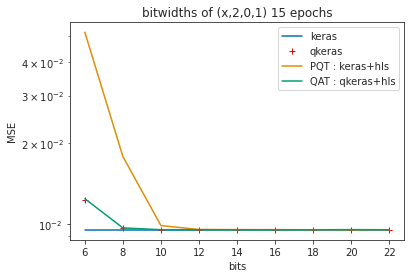

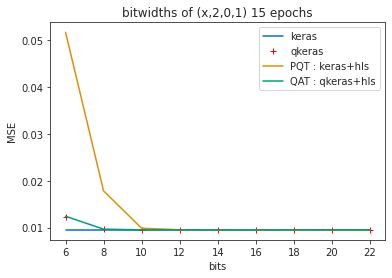

In [ ]:
plt.figure()
plt.plot(bit_scale, closs)
plt.plot(bit_scale, qloss, 'r+')
plt.plot(bit_scale, qchloss)

plt.plot(bit_scale, qhloss)   
plt.legend(['keras','qkeras','PQT : keras+hls',  'QAT : qkeras+hls'])
plt.yscale("log")
plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'bitwidths of (x,{integer},0,1) {nbr_epoch} epochs')

plt.show()

plt.figure()
plt.plot(bit_scale, closs)
plt.plot(bit_scale, qloss, 'r+')
plt.plot(bit_scale, qchloss)

plt.plot(bit_scale, qhloss)   
plt.legend(['keras','qkeras','PQT : keras+hls',  'QAT : qkeras+hls'])
plt.xlabel('bits')
plt.ylabel('MSE')
plt.title(f'bitwidths of (x,{integer},0,1) {nbr_epoch} epochs')

plt.show()

In [ ]:

for q, p, p2 in zip (qat_results, ptq_results, ptq_result_2):
    plt.plot(y)
    plt.plot(p)
    plt.plot(q)
    plt.plot(p2)

    plt.legend(['true','PTQ','QAT','PTQ2'])
    plt.show() 


NameError: name 'ptq_result_2' is not defined

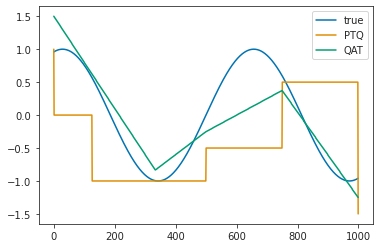

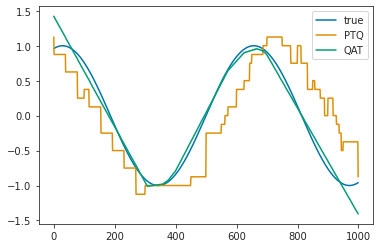

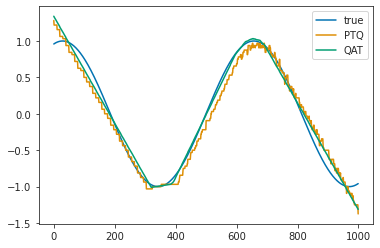

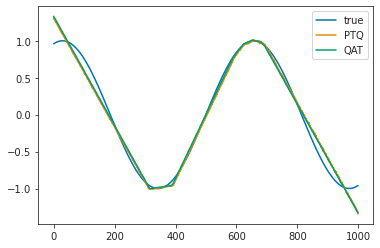

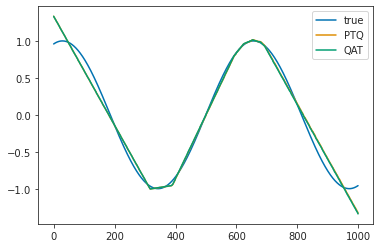

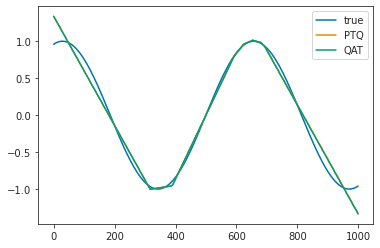

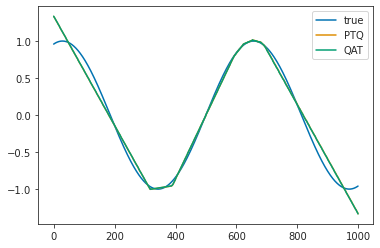

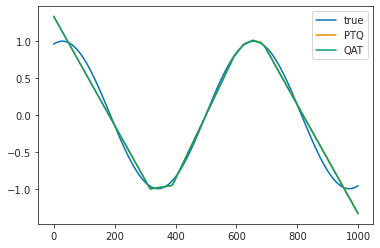

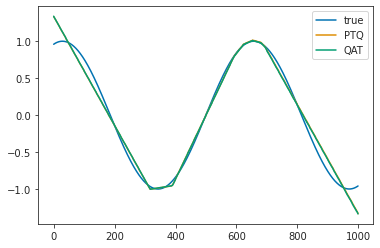

In [ ]:
for q, p in zip (qat_results, ptq_results):
    plt.plot(y)
    plt.plot(p)
    plt.plot(q)
    plt.legend(['true','PTQ','QAT'])
    plt.show() 


## Analyse of the weights

(array([1., 3., 8., 2., 8., 7., 1., 0., 0., 1.]),
 array([-2.4798443 , -1.9255514 , -1.3712585 , -0.8169656 , -0.26267266,
         0.29162025,  0.8459132 ,  1.4002061 ,  1.954499  ,  2.508792  ,
         3.0630848 ], dtype=float32),
 <BarContainer object of 10 artists>)

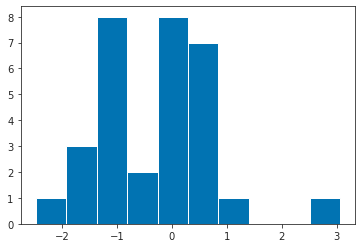

In [ ]:
plt.hist(np.concatenate([i.flatten() for i in d_model.get_weights()]))



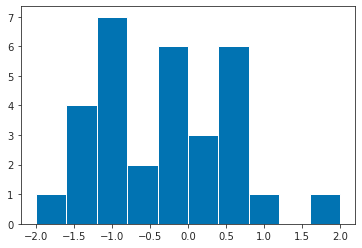

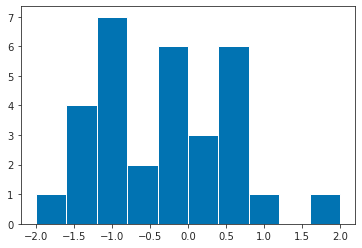

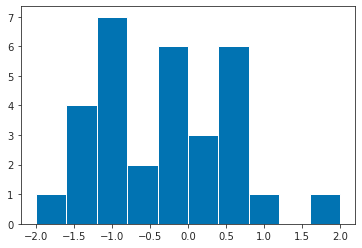

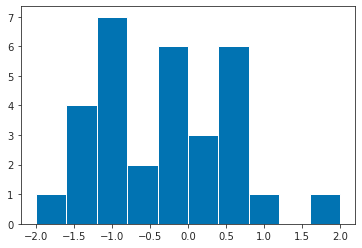

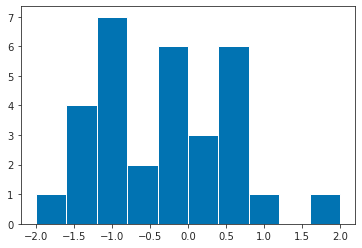

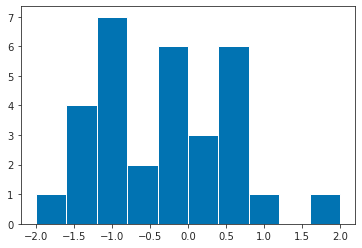

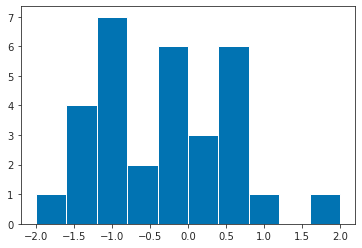

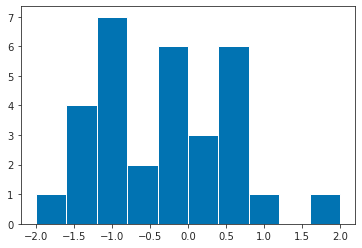

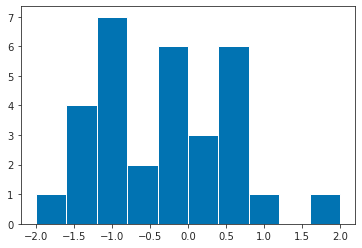

In [ ]:
for qm in qmodels:
    plt.hist(np.concatenate([i.flatten() for i in qm.get_weights()]))
    plt.show()